# Worksheet 3: Thresholds and climate statistics
The following exercises demonstrate analysis of moderate extremes in climate simulated using
PRECIS. As with the other worksheets, these are just examples of some of the analysis that you
might perform using packages such as Python and and the python Library IRIS.

<div class="alert alert-block alert-warning">
<b>By the end of this worksheet you should be able to:</b><br> 
- Have an appreciation for working with daily model data <br>
- Understand how to calculate useful climate statistics<br>
- Compare model ouput against oberved data sets<br>
</div>

## Contents
### [3.1: Frequency of Wet days](#3.1) 
### [3.2: Calculating percentiles](#3.2)

## Preamble

In [1]:
# Code preamble - these libraries will be used in this worksheet.
# This code block needs to be re-run every time you restart this worksheet!
%matplotlib inline 
import os
import iris
import iris.coord_categorisation
import iris.quickplot as qplt
import iris.plot as iplt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import dask
dask.config.set(get=dask.get)
import dask.array as da
from iris.analysis import Aggregator

# /data/users/ssadri/pyprecis/monthly
# Some helpful data locations
DATADIR = '/project/precis/worksheets/data'
APHRODIR = os.path.join(DATADIR, 'APHRODITE')
CRUDIR = os.path.join(DATADIR, 'CRU')
CLIMDIR = os.path.join(DATADIR, 'climatology')
MODELDIR = os.path.join(DATADIR, 'netcdf')
JOBIDS = ['cahpa', 'cahpb']
TIME_PERIODS = {'baseline':'1981_1983', 'future':'2021_2050'}

<div class="alert alert-block alert-success">
    <b>Question:</b> Thinking about climate extremes, what model <b>averaging period</b> should we be using for our data analysis? <br>
    How do we identify this model avergaing period in the model output <b>filenames</b>?
</div>

<a id='3.1'></a>
## 3.1 Frequency of wet days

Start by finding the frequency of wet days using daily data For both ___cahpa___ and ___cahpb___.  Calculate the number of days in both the baseline and future periods which are wet days - a wet day is defined as having precipitation >=1 mm/day.  Then calculate the percentage of wet days.


In [15]:
# For each day: Is rainfall >= 1? True/False
# Sum over all days to get number of wet days at each grid point
# Do for both model runs and time periods
# Then calcuate the percentage of wet days

# Define a new aggregator to help count non-zero days
count_nonzero = Aggregator('count', None,
                           units_func=lambda units: 1,
                           lazy_func=da.count_nonzero)

for runid in JOBIDS:
    for period in TIME_PERIODS.keys():
        # Get path to daily data
        infile = os.path.join(MODELDIR, runid, f'{runid}.pa.{TIME_PERIODS[period]}.pr.*.nc')
        data = iris.load_cube(infile)
        # Use of a custom aggregator that uses dask array to reduce memory load
        model_wetdays = data.collapsed('time', count_nonzero)
        # Save collapsed cube to netcdf
        outfile = os.path.join(CLIMDIR, f'{runid}.pa.{TIME_PERIODS[period]}.wetday.nc')
        iris.save(model_wetdays, outfile)        
        # Find wet days as a percentage of total days
        total_days = data.coord('time').shape[0]  # Note that this is a 360 day calendar!
        model_pcent_wetdays = iris.analysis.maths.divide(iris.analysis.maths.multiply(model_wetdays, 100), total_days)
        # Save output
        outfile = os.path.join(CLIMDIR, f'{runid}.pa.{TIME_PERIODS[period]}.wetday.pcent.nc')
        iris.save(model_pcent_wetdays, outfile)


Calculate numbers of wet days and percentage of wet days from the ___APHRODITE___ observations. This is an observational dataset for 1951-2015. There are 10957 days in the ___APHRODITE___ data which uses a real (365.25 day) calendar.


In [14]:
infile = os.path.join(APHRODIR, 'aphro.day.1981_1983.nc')
obs = iris.load_cube(infile, 'daily precipitation analysis interpolated onto 0.25deg grids [mm/day]')
# Find number of days in dataset
number_aphro_days = len(obs.coord('time').points)
# Find number of wet days
obs_wetdays = obs.collapsed('time', count_nonzero)
# Save ouput
outfile = os.path.join(CLIMDIR, 'aphro.wetday.nc')
iris.save(obs_wetdays, outfile)
# Find wet days percent
obs_pcent_wetdays = iris.analysis.maths.divide(iris.analysis.maths.multiply(obs_wetdays, 100), number_aphro_days)
outfile = os.path.join(CLIMDIR, 'aphro.wetday.pcent.nc')
iris.save(obs_pcent_wetdays, outfile)

/opt/scitools/environments/experimental/2018_10_16-1/lib/python3.6/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1737: UserWarning: Skipping global attribute 'calendar': 'calendar' is not a permitted attribute
  warnings.warn(msg.format(attr_name, str(e)))
/opt/scitools/environments/experimental/2018_10_16-1/lib/python3.6/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1737: UserWarning: Skipping global attribute 'calendar': 'calendar' is not a permitted attribute
  warnings.warn(msg.format(attr_name, str(e)))
/opt/scitools/environments/experimental/2018_10_16-1/lib/python3.6/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))


<div class="alert alert-block alert-success">
    <b>Question:</b> Are there any additional considerations that have to be made with daily data? <br>
    From a coding perspective, how does working with daily data compare to working with monthly data?
</div>

### Plotting

/opt/scitools/environments/experimental/2018_10_16-1/lib/python3.6/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1725: UnknownCellMethodWarning: NetCDF variable 'precipitation_flux' contains unknown cell method 'count'
  warnings.warn(message=msg, category=UnknownCellMethodWarning)
/opt/scitools/environments/experimental/2018_10_16-1/lib/python3.6/site-packages/iris/coords.py:1138: UserWarning: Coordinate 'grid_longitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
/opt/scitools/environments/experimental/2018_10_16-1/lib/python3.6/site-packages/iris/coords.py:1138: UserWarning: Coordinate 'grid_latitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
/opt/scitools/environments/experimental/2018_10_16-1/lib/python3.6/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1725: UnknownCellMethodWarning: NetCDF variable 'precipitation_flux' contains unknown c

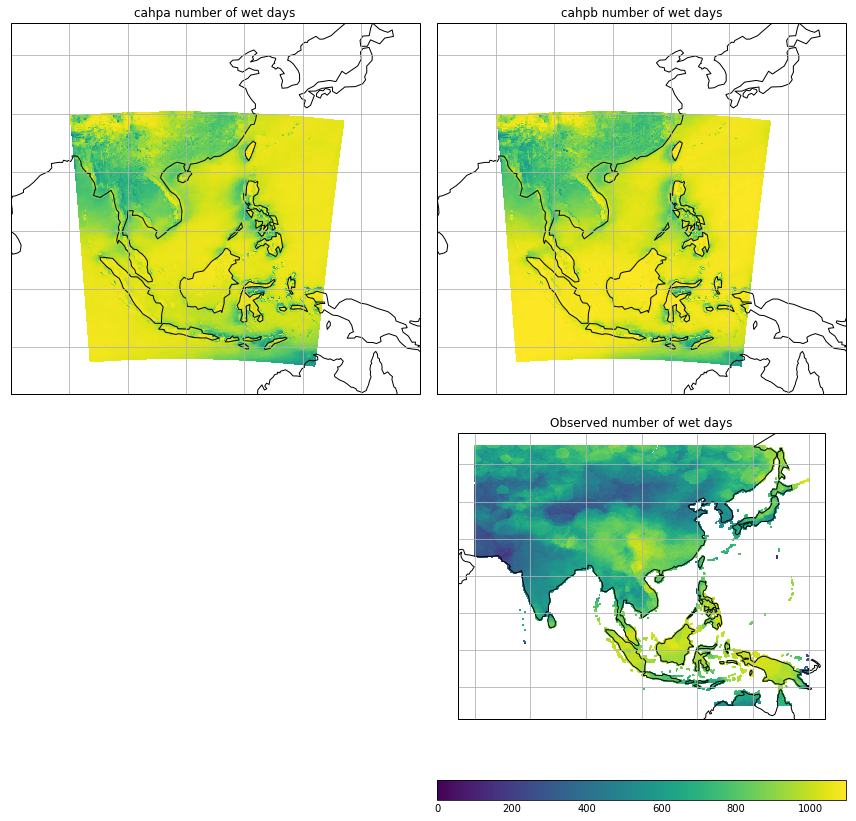

In [23]:
# Plot modelled and observed numbers of wet days and percentages of wet days
# Create a figure of the size 12x12 inches for plots
fig = plt.figure(figsize=(12, 12))

# Read in the percentage differences in precipitation between the models and obs, and plot them.
for n, runid in enumerate(JOBIDS):
    # Load baseline data
    infile = os.path.join(CLIMDIR, f'{runid}.pa.1981_1983.wetday.nc')
    nwetdays = iris.load_cube(infile)
    plotnum = 1 + n*2
    ax1 = fig.add_subplot(2, 2, n+1, projection=ccrs.PlateCarree())
    iplt.pcolormesh(nwetdays, vmin=0, vmax=number_aphro_days)
    plt.title(runid + ' number of wet days')
    ax1.coastlines()             # adds coastlines defined by the axes of the plot
    ax1.gridlines()              # adds x and y grid lines to the plot
    ax1.grid(True)
    ax1.set_extent([80,150,-15,40])

# Plot APHRODITE data
infile = os.path.join(CLIMDIR, 'aphro.wetday.nc')
obs_nwetdays = iris.load_cube(infile)
fig.add_subplot(2, 2, 4, projection=ccrs.PlateCarree())
qplt.pcolormesh(obs_nwetdays, vmin=0, vmax=number_aphro_days)
plt.title('Observed number of wet days')
ax = plt.gca()              # gca function that returns the current axes
ax.coastlines()             # adds coastlines defined by the axes of the plot
ax.gridlines()              # adds x and y grid lines to the plot

plt.tight_layout()          # automatically adjusts subplot(s) to fit in to the figure area
plt.show()

Calculate the difference in modelled future and baseline wet day frequency and also modelled baseline and
observation wet day frequency.

In [38]:
# Load percentage of wet days data for the APHRODITE observations
infile = os.path.join(CLIMDIR, 'aphro.wetday.pcent.nc')
obs = iris.load_cube(infile)
# Add coordinate system information to facilitate regridding later
wgs84_cs = iris.coord_systems.GeogCS(6371229.0) 
obs.coord('latitude').coord_system = wgs84_cs 
obs.coord('longitude').coord_system = wgs84_cs

# The observed rainfall data have been created using surface rain gauges, and so are only available
# over land points.  Define a mask to remove sea points. The mask is True for masked points.
mask = np.where(obs.data > 0.0, False, True)

# Redefine the data array of the obs as a masked array.
obs.data = np.ma.array(obs.data, mask=mask)

# Define regridding method
scheme = iris.analysis.Linear(extrapolation_mode='mask')

for runid in JOBIDS:
    infile = os.path.join(CLIMDIR, f'{runid}.pa.{TIME_PERIODS["baseline"]}.wetday.pcent.nc')
    model_baseline = iris.load_cube(infile)
    infile = os.path.join(CLIMDIR, f'{runid}.pa.{TIME_PERIODS["future"]}.wetday.pcent.nc')
    model_future = iris.load_cube(infile)
    # In order to compare the modelled and observed numbers of wet days,
    # need to regrid the percentage differences from the model to the APHRODITE grid
    model_baseline_rg = model_baseline.regrid(obs, scheme)
    model_future_rg = model_future.regrid(obs, scheme)

    # Find the difference between futue and baseline models
    diff_model = iris.analysis.maths.subtract(model_future_rg, model_baseline_rg)
    outfile = os.path.join(CLIMDIR, f'{runid}.wetday.pcent.diff.nc')
    iris.save(diff_model, outfile)

    # Subtract the observed percentages of wet days from the modelled percentages
    diff_mod_obs = obs.copy()
    diff_mod_obs.data = model_baseline_rg.data - obs.data
    outfile = os.path.join(CLIMDIR, f'{runid}.wetday.pcent.obs_diff.nc')
    iris.save(diff_mod_obs, outfile)

Plot the difference in the percentage of wet day frequency between the models and observations.  The model domain is smaller than the observations domain, so we select the model domain when plotting using the `cube.intersection` method.


/opt/scitools/environments/experimental/2018_10_16-1/lib/python3.6/site-packages/iris/coords.py:1138: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
/opt/scitools/environments/experimental/2018_10_16-1/lib/python3.6/site-packages/iris/coords.py:1138: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
/opt/scitools/environments/experimental/2018_10_16-1/lib/python3.6/site-packages/iris/coords.py:1138: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
/opt/scitools/environments/experimental/2018_10_16-1/lib/python3.6/site-packages/iris/coords.py:1138: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
/opt/scitools/environments/experimental/2018_10_16-1/lib/python3.6/site-packages/iris/coords.py:11

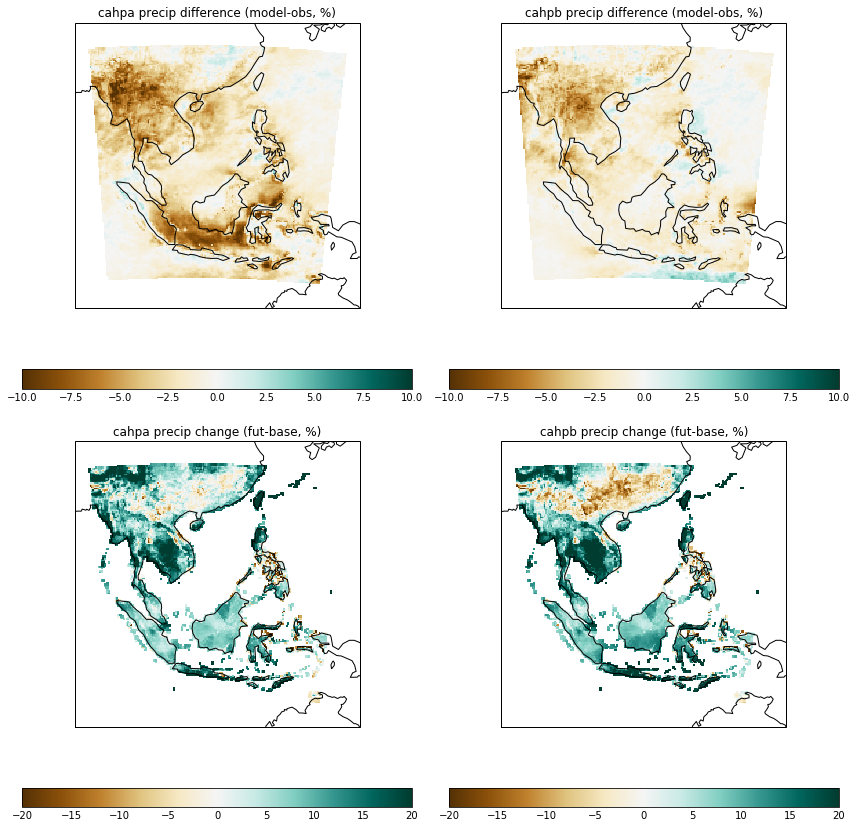

In [51]:
# Create a figure of the size 12x12 inches
plt.figure(figsize=(12, 12))

# Read in the percentage differences in precipitation between the models and obs, and plot them.

for n, runid in enumerate(JOBIDS):
    infile = os.path.join(CLIMDIR, f'{runid}.wetday.pcent.diff.nc')
    pcent_diff = iris.load_cube(infile)
    plt.subplot(2, 2, n+1)
    qplt.pcolormesh(pcent_diff.intersection(longitude=(90, 137), latitude=(-20, 32)), 
                    vmax=10, vmin=-10, cmap='BrBG')
    plt.title(runid + ' precip difference (model-obs, %)')
    ax = plt.gca()
    ax.coastlines()

for n, runid in enumerate(JOBIDS):
    infile = os.path.join(CLIMDIR, f'{runid}.wetday.pcent.obs_diff.nc')
    pcent_diff = iris.load_cube(infile)
    plt.subplot(2, 2, n+3)
    qplt.pcolormesh(pcent_diff.intersection(longitude=(90, 137), latitude=(-20, 32)), 
                    vmax=20, vmin=-20, cmap='BrBG')
    plt.title(runid + ' precip change (fut-base, %)')
    ax = plt.gca()
    ax.coastlines()

plt.tight_layout()
plt.show()

<a id='3.2'></a>
## 3.2. Calculating percentiles

Calculate in mm/day the baseline (1961-1990) and future (2021-2050) 95th percentile of precipitation. Do this for cahpa, cahpb and also for APHRODITE baseline


In [54]:
for runid in JOBIDS:
    for t in TIME_PERIODS.keys():
        infile = os.path.join(MODELDIR, runid, f'{runid}.pa.{TIME_PERIODS[t]}.pr.norim.mmday-1.nc')
        model_precip = iris.load_cube(infile)
        model_pc95 = model_precip.collapsed('time', iris.analysis.PERCENTILE, percent=95.0)
        outfile = os.path.join(CLIMDIR, f'{runid}.pa.pc95.{TIME_PERIODS[t]}.pr.norim.mmday-1.nc')
        iris.save(model_pc95, outfile)

In [56]:
# Repeat for the APHRODITE data
# Define a mask to remove the sea points, as there are no observations over the sea.
infile = os.path.join(CLIMDIR, 'aphro.wetday.nc')
obs_wetday_no = iris.load_cube(infile)
mask = np.where(obs_wetday_no.data > 0.0, False, True)

infile = os.path.join(APHRODIR, 'aphro.day.1981_1983.nc')
obs_precip = iris.load_cube(infile, 'daily precipitation analysis interpolated onto 0.25deg grids [mm/day]')
obs_pc95 = obs_precip.collapsed('time', iris.analysis.PERCENTILE, percent=95.0)

# Redefine the data array of pc95 as a masked array.
obs_pc95.data = np.ma.array(obs_pc95.data, mask=mask)
outfile = os.path.join(CLIMDIR, 'aphro.pc95.1981_1983.mmday-1.nc')
iris.save(obs_pc95, outfile)

/opt/scitools/environments/experimental/2018_10_16-1/lib/python3.6/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1725: UnknownCellMethodWarning: NetCDF variable 'precip' contains unknown cell method 'count'
  warnings.warn(message=msg, category=UnknownCellMethodWarning)
/opt/scitools/environments/experimental/2018_10_16-1/lib/python3.6/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1737: UserWarning: Skipping global attribute 'calendar': 'calendar' is not a permitted attribute
  warnings.warn(msg.format(attr_name, str(e)))
/opt/scitools/environments/experimental/2018_10_16-1/lib/python3.6/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1737: UserWarning: Skipping global attribute 'calendar': 'calendar' is not a permitted attribute
  warnings.warn(msg.format(attr_name, str(e)))
/opt/scitools/environments/experimental/2018_10_16-1/lib/python3.6/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non


Calculate the difference between the future and baseline, and baseline and APHRODITE observations 95th percentiles of precipitation.


In [59]:
# Load aphrodite data
infile = os.path.join(CLIMDIR, 'aphro.pc95.1981_1983.mmday-1.nc')
obs_cube = iris.load_cube(infile)
obs_cube.coord('latitude').coord_system = wgs84_cs 
obs_cube.coord('longitude').coord_system = wgs84_cs

# Define regridding method
scheme = iris.analysis.Linear(extrapolation_mode='mask')

for runid in JOBIDS:
    # First, calculate the difference between the modelled future and baseline 95th percentiles
    infile = os.path.join(CLIMDIR, f'{runid}.pa.pc95.1981_1983.pr.norim.mmday-1.nc')
    model_base = iris.load_cube(infile)
    infile = os.path.join(CLIMDIR, f'{runid}.pa.pc95.2021_2050.pr.norim.mmday-1.nc')
    model_fut = iris.load_cube(infile)
    diff = iris.analysis.maths.subtract(model_fut, model_base)
    outfile = os.path.join(CLIMDIR, f'{runid}.pa.pc95.diff.pr.mmday-1.nc')
    iris.save(diff, outfile)

    # Next, calculate the differences between the modelled baseline and observed 95th percentiles
    # To compare the model and observations, the model data need to be regridded
    model_base_rg = model_base.regrid(obs_cube, scheme)
    diff_mod_obs = obs_cube.copy()
    diff_mod_obs.data = model_base_rg.data - obs_cube.data

    outfile = os.path.join(CLIMDIR, f'{runid}.pa.pc95.obs_diff.pr.mmday-1.nc')
    iris.save(diff_mod_obs, outfile)

Plot the differences in the 95th percentiles between the models and observations, and the future changes in the 95th percentiles of precipitation from both models.

/opt/scitools/environments/experimental/2018_10_16-1/lib/python3.6/site-packages/iris/coords.py:1138: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
/opt/scitools/environments/experimental/2018_10_16-1/lib/python3.6/site-packages/iris/coords.py:1138: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
/opt/scitools/environments/experimental/2018_10_16-1/lib/python3.6/site-packages/iris/coords.py:1138: UserWarning: Coordinate 'grid_longitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
/opt/scitools/environments/experimental/2018_10_16-1/lib/python3.6/site-packages/iris/coords.py:1138: UserWarning: Coordinate 'grid_latitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
/opt/scitools/environments/experimental/2018_10_16-1/lib/python3.6/site-packages/iris/co

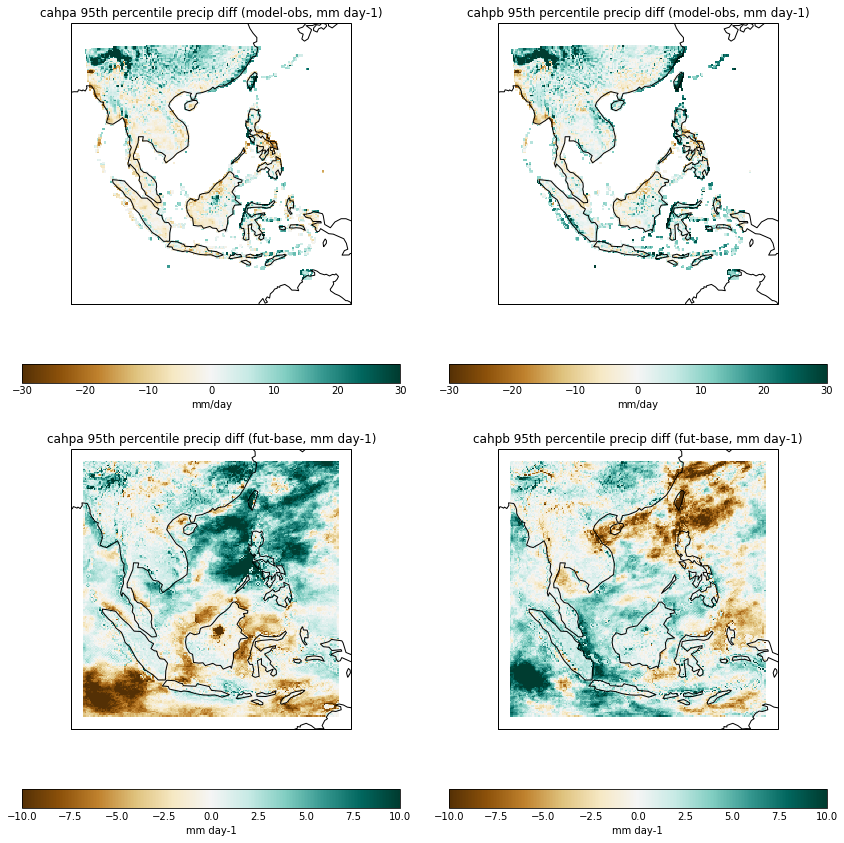

In [63]:
# Create a figure of the size 12x12 inches
plt.figure(figsize=(12, 12))

# Read in the percentage differences in precipitation between the models and obs, and plot them.
for n, runid in enumerate(JOBIDS):
    infile = os.path.join(CLIMDIR, f'{runid}.pa.pc95.obs_diff.pr.mmday-1.nc')
    pc95_diff = iris.load_cube(infile)
    plt.subplot(2, 2, n+1)
    qplt.pcolormesh(pc95_diff.intersection(longitude=(90, 137), latitude=(-20, 32)), 
                    vmax=30, vmin=-30, cmap='BrBG')
    plt.title(runid + ' 95th percentile precip diff (model-obs, mm day-1)')
    ax = plt.gca()              # gca function that returns the current axes
    ax.coastlines()             # adds coastlines defined by the axes of the plot

    infile = os.path.join(CLIMDIR, f'{runid}.pa.pc95.diff.pr.mmday-1.nc')
    pc95_diff = iris.load_cube(infile)
    plt.subplot(2, 2, n+3)
    qplt.pcolormesh(pc95_diff, vmax=10, vmin=-10, cmap='BrBG')
    plt.title(runid + ' 95th percentile precip diff (fut-base, mm day-1)')
    ax = plt.gca()              # gca function that returns the current axes
    ax.coastlines()             # adds coastlines defined by the axes of the plot

plt.tight_layout()
plt.show()

© Crown Copyright 2018, Met Office